## Import libraries 


In [7]:
import pandas as pd
import scipy.stats as sps
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import zscore

## KS AND FDR

In [8]:
##Generate training_testing & oot 
##only use tt to do feature selection
tt = pd.read_csv("Create variables_traintest.csv")
oot = pd.read_csv("Create variables_oot.csv")

In [9]:
#fix datatime 
tt['date'] = pd.to_datetime(tt['date'])

In [10]:
# ls = list(tt.columns)
# ls

In [12]:
#remove first two weeks 
tt_df = tt.drop(tt[tt.date < '2010-01-15'].index)

#drop useless cols 
tt_df.drop(['record', 'date','amount','merchdes','card','merch#','weekday','weekday_risk'],
           axis=1,inplace=True)

#Get target here to add later after z schale
tt_y = tt_df[tt_df.columns[302]]

#z scale all cols expect 'fraud' and the column is constant

tt_df = tt_df[tt_df.columns[0:302]].apply(lambda x: x if np.std(x) == 0 else zscore(x))
tt_df['fraud'] = tt_y.values

In [15]:
tt_df.shape

(69874, 303)

In [16]:
#create variable list 
variables = list(tt.columns)
for col in ['record', 'date','amount','merchdes','card','merch#','weekday','weekday_risk']:
    variables.remove(col)
len(variables)
# variables

303

In [17]:
#Build KS & FDR Dataframe 
KSFDR = pd.DataFrame({'var': range(0,303)})

i=0
for variable in variables :
    KSFDR['var'][i] = variables[i]
    i=i+1

KSFDR["ks"] = ""
KSFDR["FDR"] = ""

In [18]:
#Calculate KS

goods = tt_df[tt_df.fraud == 0]
bads = tt_df[tt_df.fraud == 1] 

i = 0
for column in tt_df:
    KSFDR['ks'][i] = sps.ks_2samp(goods[column],bads[column])[0]
    i = i+1

In [19]:
#Calculate FDR
topRows = int(round(len(tt_df)*0.03))

j = 0
for column in tt_df:
    temp1 = tt_df.sort_values(column,ascending=False).head(topRows)
    temp2 = tt_df.sort_values(column,ascending=True).head(topRows)
    needed1 = temp1.loc[:,'fraud']
    needed2 = temp2.loc[:,'fraud']
    FDR1 = sum(needed1)/len(bads)
    FDR2 = sum(needed2)/len(bads)
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j +1

In [20]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)
KSFDR

,var,ks,FDR,rank_ks,rank_FDR,average_rank
302,fraud,1,1,303.0,303.0,303.00
300,U*_merch#,0.215782,0.0998632,301.0,302.0,301.50
97,merch#_ps_3d_ActualTotal,0.0395052,0.0752394,293.5,300.0,296.75
67,merch#_#d_since,0.0545365,0.0588235,297.0,294.0,295.50
282,card-state_ps_7d_ActualTotal,0.0400114,0.0533516,295.0,288.5,291.75
188,card-merchant_ps_30d_ActualTotal,0.0352368,0.0629275,284.0,297.5,290.75
244,card-state_#d_since,0.0375802,0.0560876,288.0,293.0,290.50
134,card-merchant_#d_since,0.130213,0.0478796,300.0,280.0,290.00
180,card-merchant_ps_14d_ActualTotal,0.0326303,0.0656635,274.5,299.0,286.75
73,merch#_ps_30d_count,0.0388647,0.0492476,290.5,283.0,286.75


In [ ]:
#check random and fraud variables

# KSFDR.loc[KSFDR['var'] == 'fraud'] 
# KSFDR.loc[KSFDR['var'] == 'random'] 

In [21]:
KSFDR.to_csv('KSFDR_v4.csv', index=False)

## Feature Selection - Wrapper 

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
#drop 'random', 'fraud' and select top 80 variables from KSFDR 
DFfs = KSFDR.loc[~((KSFDR['var']=='fraud') | (KSFDR['var']=='random'))]
var_top80 = DFfs.nlargest(80,['average_rank']).copy()
var_top80_list = list(var_top80['var'])
var_top80_list

['U*_merch#',
 'merch#_ps_3d_ActualTotal',
 'merch#_#d_since',
 'card-state_ps_7d_ActualTotal',
 'card-merchant_ps_30d_ActualTotal',
 'card-state_#d_since',
 'card-merchant_#d_since',
 'card-merchant_ps_14d_ActualTotal',
 'merch#_ps_30d_count',
 'merch#_ps_14d_ActualTotal',
 'merch#_ps_30d_ActualTotal',
 'merch#_ps_0d_ps30d_number',
 'merch#_ps_14d_count',
 'card-zip_ps_30d_ActualTotal',
 'card_ps_1d_ps30d_number',
 'card_ps_14d_ActualTotal',
 'card-zip_ps_14d_ActualTotal',
 'merch#_ps_7d_ActualTotal',
 'card_#d_since',
 'card_ps_30d_count',
 'card_ps_0d_ps30d_number',
 'card-zip_#d_since',
 'card_ps_30d_ActualTotal',
 'merch#_ps_7d_count',
 'card_ps_1d_ps7d_number',
 'card_ps_30d_total',
 'card_ps_0d_ps14d_number',
 'card_ps_0d_ps7d_number',
 'card-state_ps_14d_ActualTotal',
 'card-zip_ps_14d_total',
 'card-state_ps_30d_ActualTotal',
 'card-merchant_ps_7d_ActualTotal',
 'card_ps_7d_ActualTotal',
 'card_ps_14d_count',
 'merch#_ps_1d_ps30d_number',
 'card_ps_1d_count',
 'card_ps_3d_coun

### RFECV 

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

##build modeling data x and y here

#split x and y 
tt_x = tt_df[tt_df.columns.intersection(var_top80_list)]
tt_y = tt_df['fraud']

#building X & Y array here
tt_X = np.array(tt_x)
tt_Y = np.array(tt_y)

In [25]:
#try RRECV with 80 variables 
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')
rfecv.fit(tt_X, tt_Y)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=3)

In [26]:
var80_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), tt_x.columns)),
                            columns = ['ranking', 'variable'])
var80_selected.head(50)

,ranking,variable
0,1,U*_merch#
1,1,card-merchant_#d_since
2,1,card-merchant_ps_14d_ActualTotal
3,1,card-merchant_ps_14d_total
4,1,card-merchant_ps_3d_total
5,1,card-zip_ps_14d_ActualTotal
6,1,card-zip_ps_14d_total
7,1,card-zip_ps_30d_ActualTotal
8,1,card_ps_0d_ps14d_number
9,1,card_ps_0d_ps30d_number


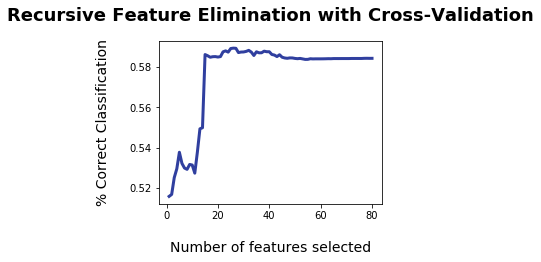

In [27]:
plt.figure(figsize=(4, 3))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [29]:
#store selected top 33 variables   
var_top26 = var80_selected.iloc[:34]
var_top26_list = list(var_top26['variable'])
print(var_top26_list)

['U*_merch#', 'card-merchant_#d_since', 'card-merchant_ps_14d_ActualTotal', 'card-merchant_ps_14d_total', 'card-merchant_ps_3d_total', 'card-zip_ps_14d_ActualTotal', 'card-zip_ps_14d_total', 'card-zip_ps_30d_ActualTotal', 'card_ps_0d_ps14d_number', 'card_ps_0d_ps30d_number', 'card_ps_14d_ActualTotal', 'card_ps_14d_total', 'card_ps_1d_count', 'card_ps_1d_ps14d_number', 'card_ps_1d_ps7d_number', 'card_ps_30d_ActualTotal', 'card_ps_30d_total', 'card_ps_7d_ActualTotal', 'card_ps_7d_count', 'merch#_ps_0d_ps30d_amount', 'merch#_ps_14d_count', 'merch#_ps_14d_total', 'merch#_ps_1d_ps30d_amount', 'merch#_ps_3d_ActualTotal', 'merch#_ps_3d_count', 'merch#_ps_7d_total', 'merch#_ps_14d_ActualTotal', 'merch#_ps_1d_ps30d_number', 'card-state_ps_3d_total', 'card-state_ps_14d_total', 'card-merchant_ps_7d_ActualTotal', 'card-zip_#d_since', 'merch#_ps_1d_ps14d_number', 'merch#_ps_1d_ps7d_number']


In [30]:
var_top26.to_csv('wrapper_top26.csv')
var80_selected.to_csv('variable_ranking.csv')

### RFECV 2nd （50-30）

In [ ]:
# ##rebuild modeling data x with 50 variables

# tt_x2 = tt_x[tt_x.columns.intersection(var_top50_list)]
# tt_X2 = np.array(tt_x2)

In [ ]:
# #try RRECV with 80 variables 
# model = LogisticRegression()
# rfecv2 = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')
# rfecv2.fit(tt_X2, tt_Y)

In [ ]:
# var50_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv2.ranking_), tt_x2.columns)),
#                             columns = ['ranking', 'variable'])
# var80_selected.head(50)